## Package imports, global variables and functions

In [2]:
import mysql.connector
import json
import csv
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 15]

host = "localhost"
un = "root"
pw=""
db_name = "yelp"

def mysql_result_to_df(result, cursor):
    field_names = [i[0] for i in mycursor.description]
    return pd.DataFrame(myresult, columns=field_names)

def flatten_json(y):
    """
    Converts complex/nested JSON to table format.
    """
    out = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i += 1
        else:
            out[name[:-1]] = x

    flatten(y)
    return out

def bool_str_to_int(l):
    """
    Converts a list filled with bool values as string
    to int. Helpful for summing True (1) values
    """
    result = []
    for elem in l:
        if(elem == True or elem == "True"):
            result.append(1)
        elif(elem == False or elem =="False"):
            result.append(0)
        else:
            result.append(float("nan"))
    return result

def bool_str_to_bool(l):
    """
    Converts a list filled with bool values as string
    to bool.
    """
    result = []
    for elem in l:
        if(elem == True or elem == "True"):
            result.append(True)
        elif(elem == False or elem =="False"):
            result.append(False)
        else:
            result.append(float("nan"))
    return result

def df_to_csv(df, fp, ext=".csv", na_rep=""):
    try:
        df.to_csv(fp + ext, encoding="utf-8", header = True,\
            doublequote = True, sep=",", index=False, na_rep=na_rep)
    except Exception as e:
        print("Error: {}".format(str(e)))
        
fp = "C:/Users/Tolis/Documents/Data Analytics Cource/CKME136 X10/Project/data/final/summary"

## Connect to yelp db and load business table

In [3]:
mydb = mysql.connector.connect(
  host=host,
  user=un,
  passwd=pw,
  database=db_name
)

mycursor = mydb.cursor()

mycursor.execute("SELECT * FROM business")

myresult = mycursor.fetchall()

business_df = mysql_result_to_df(myresult, mycursor)

#Stars gets imported as a string, so convert to decimal
business_df["stars"] = business_df["stars"].apply(lambda val: float(val))

print(business_df[0:10])

mycursor.close()
mydb.close()


              business_id                               name  \
0  --1UhMGODdWsrMastO9DZw                   The Spicy Amigos   
1  --6MefnULPED_I942VcFNA      John's Chinese BBQ Restaurant   
2  --7zmmkVg-IMGaXbuVd0SQ                     Primal Brewery   
3  --8LPVSo5i0Oo61X01sV9A  Valley Bone and Joint Specialists   
4  --9QQLMTbFzLJ_oT-ON3Xw                        Great Clips   
5  --9e1ONYQuAa-CB_Rrw7Tw               Delmonico Steakhouse   
6  --DaPTJW3-tB1vP-PfdTEg                    Sunnyside Grill   
7  --DdmeR16TRb3LsjG0ejrQ           World Food Championships   
8  --EF5N7P70J_UYBTPypYlA                        MV Nail Spa   
9  --EX4rRznJrltyn-34Jz1w                  Bath & Body Works   

                                      address           city state  \
0                             821 4 Avenue SW        Calgary    AB   
1  328 Highway 7 E, Chalmers Gate 11, Unit 10  Richmond Hill    ON   
2                    16432 Old Statesville Rd   Huntersville    NC   
3              

## Flatten atrributes field which is a json object.
<p>Data may be sparse due to the semi-structured json model. However, some fields may yield useful information.</p>

In [4]:
business_attributes = business_df["attributes"]

In [5]:
business_attributes_json = []
for r in business_attributes:
    r_json = json.loads(r)
    business_attributes_json.append(r_json)
print(business_attributes)

0         {"Caters": "None", "Alcohol": "u'beer_and_wine...
1         {"WiFi": "u'no'", "HasTV": "False", "Caters": ...
2         {"Caters": "False", "BikeParking": "True", "Bu...
3         {"ByAppointmentOnly": "True", "BusinessAccepts...
4         {"GoodForKids": "True", "BusinessParking": "No...
                                ...                        
192604    {"WiFi": "u'free'", "HasTV": "False", "Alcohol...
192605    {"WiFi": "'free'", "HasTV": "True", "Music": "...
192606    {"WiFi": "u'no'", "HasTV": "True", "Caters": "...
192607    {"WiFi": "u'no'", "HasTV": "True", "Caters": "...
192608    {"WiFi": "'no'", "HasTV": "True", "Caters": "T...
Name: attributes, Length: 192609, dtype: object


In [6]:
business_attr_flat = json_normalize(business_attributes_json)
print(business_attr_flat.columns)

Index(['Caters', 'Alcohol', 'NoiseLevel', 'GoodForKids', 'GoodForMeal',
       'OutdoorSeating', 'BusinessParking', 'RestaurantsAttire',
       'RestaurantsTakeOut', 'RestaurantsDelivery', 'RestaurantsPriceRange2',
       'RestaurantsTableService', 'RestaurantsGoodForGroups', 'WiFi', 'HasTV',
       'Ambience', 'BikeParking', 'RestaurantsReservations',
       'BusinessAcceptsCreditCards', 'WheelchairAccessible',
       'ByAppointmentOnly', 'Corkage', 'BYOBCorkage', 'Music', 'HappyHour',
       'BestNights', 'Smoking', 'CoatCheck', 'GoodForDancing',
       'AcceptsInsurance', 'AgesAllowed', 'BusinessAcceptsBitcoin',
       'DogsAllowed', 'DriveThru', 'DietaryRestrictions', 'HairSpecializesIn',
       'BYOB', 'Open24Hours', 'RestaurantsCounterService'],
      dtype='object')


## Transform nested object literals obtained from yelp attributes JSON.
<p>This is to make these fields produce some type of useful information.</p>

In [7]:
"""
    The functions below are used to transform yelp json object literals
    to a usable value such as a count, or a boolean True/False.
"""

def yelp_json_list_format(ylist):
    result = (str(ylist).replace("'", "\""))
    result = (result.replace("True", "\"True\""))
    result = (result.replace("False", "\"False\""))
    return result
    
def get_yelp_list_count(val):
    """
    Counts the amount of times a propery from a
    yelp object literal evaluates to True and returns
    the amount.
    """
    #Load obj lit
    result = yelp_json_list_format(val)
    
    #On error return nan
    #This would happen due to empty fields.
    try:
        result = json.loads(result)
        
        #bools as strings
        vals = list(result.values())
        #bools as int - True: 1, False: 0
        vals = bool_str_to_int(vals)
        #Total Count
        return sum(vals)
    except:
        return float('nan')
    
def get_yelp_list_count_keys(val):
    """
    Counts the amount of keys a
    yelp object literal has and returns
    the amount.
    """
    #Load obj lit
    result = yelp_json_list_format(val)
    
    try:
        result = json.loads(result)
        key_count = len(result.keys())
        
        #Return None if no keys are found.
        if(key_count==0):
            return None
        return key_count
    except:
        return None

def has_weekend_check(val):
    """
    Specific function for 'hours' field in the business table.
    This loops through the yelp obj lit and checks to see if any
    keys are equal to saturday or sunday.
    A value of True/False will be returned if a match is found.
    """
    result = yelp_json_list_format(val)
    bool_list = []
    try:
        result = json.loads(result)
        
        vals = list(result.keys())
        
        for v in vals:
            bool_check = v.lower() == "saturday" or v.lower() =="sunday"
            bool_list.append(bool_check)
        
        return any(bool_list)

    except:
        return float('nan')


def get_yelp_list_keys(val):
    """
    Returns keys from a obj lit if their values evaluate to True.
    """

    result = yelp_json_list_format(val)
    true_keys = []
    try:
        result = json.loads(result)
        
        for k,v in result.items():   
            if(v==True or v=="True"): 
                true_keys.append(k)
        return true_keys
    except:
        return float('nan')

def has_music_check(val):
    """
    Specific function for 'music' field in the business table.
    This loops through the yelp obj lit and checks to see if any
    keys are equal to True.
    A value of True/False will be returned if any keys are equal to True.
    """
    
    result = yelp_json_list_format(val)
   
    try:
        result = json.loads(result)
      
        if("no_music" in result and 
           (result["no_music"]=="True" or result["no_music"]==True)):
            return False
        
        vals = list(result.values())
        vals = bool_str_to_bool(vals)
        return any(vals)
        
    except:
        return float('nan')

"""
Declare calculated fields for json object literal provided by yelp.
These object literals contain multiple keys that map to boolean values (for the most part). 

Example:

Field: BusinessParking
Value: "{'garage': True, 'street': False, 'validated': False, 'lot': True, 'valet': False}"

Transforming these objects to a list of categores, a single number (count), or a boolen field makes them easier to analyze.
Example Transfromation of BusinessParking using count:

Field: BusinessParking_Count
value: 2 (count all True values)
"""

business_attr_flat["CALC_BusinessParking_Count"] = business_attr_flat["BusinessParking"].apply(get_yelp_list_count)
business_attr_flat["CALC_GoodForMeal_Count"] = business_attr_flat["GoodForMeal"].apply(get_yelp_list_count)
business_attr_flat["CALC_Music_HasMusic"] = business_attr_flat["Music"].apply(has_music_check)
business_attr_flat["CALC_BestNights_Count"] = business_attr_flat["BestNights"].apply(get_yelp_list_count)
business_attr_flat["CALC_Ambience_Count"] = business_attr_flat["Ambience"].apply(get_yelp_list_count)
business_attr_flat["CALC_DietaryRestrictions_Count"] = business_attr_flat["DietaryRestrictions"].apply(get_yelp_list_count)
business_attr_flat["CALC_HairSpecializesIn_Count"] = business_attr_flat["HairSpecializesIn"].apply(get_yelp_list_count)

transformed_fields = ["BusinessParking", 
                      "GoodForMeal",
                      "Music",
                      "BestNights",
                      "Ambience",
                      "DietaryRestrictions",
                      "HairSpecializesIn"]

    
print("Transformed:",", ".join(transformed_fields))

Transformed: BusinessParking, GoodForMeal, Music, BestNights, Ambience, DietaryRestrictions, HairSpecializesIn


## Concat flattened attribute field to original business data and print fields

In [8]:
business_df_flat = pd.concat([business_df,business_attr_flat], axis=1)
business_df_flat = business_df_flat.replace(r'^\s*$', np.nan, regex=True)
business_df_flat = business_df_flat.replace(r'^{}*$', np.nan, regex=True)
print(business_df_flat.columns)

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'is_open',
       'attributes', 'categories', 'hours', 'Caters', 'Alcohol', 'NoiseLevel',
       'GoodForKids', 'GoodForMeal', 'OutdoorSeating', 'BusinessParking',
       'RestaurantsAttire', 'RestaurantsTakeOut', 'RestaurantsDelivery',
       'RestaurantsPriceRange2', 'RestaurantsTableService',
       'RestaurantsGoodForGroups', 'WiFi', 'HasTV', 'Ambience', 'BikeParking',
       'RestaurantsReservations', 'BusinessAcceptsCreditCards',
       'WheelchairAccessible', 'ByAppointmentOnly', 'Corkage', 'BYOBCorkage',
       'Music', 'HappyHour', 'BestNights', 'Smoking', 'CoatCheck',
       'GoodForDancing', 'AcceptsInsurance', 'AgesAllowed',
       'BusinessAcceptsBitcoin', 'DogsAllowed', 'DriveThru',
       'DietaryRestrictions', 'HairSpecializesIn', 'BYOB', 'Open24Hours',
       'RestaurantsCounterService', 'CALC_BusinessParking_Count',
       'CALC_GoodForMeal

In [9]:
#Calculates amount of days open a week and if open on weekends via hours json lit.
business_df_flat["CALC_days_open"] = business_df_flat["hours"].apply(get_yelp_list_count_keys)
business_df_flat["CALC_has_weekend"] = business_df_flat["hours"].apply(has_weekend_check)

## Numeric summaries for business table

In [10]:
#Description of quantitative fields.
df_description_number = business_df_flat.describe(include=[np.number])
print(df_description_number)

            latitude      longitude          stars   review_count  \
count  192609.000000  192609.000000  192609.000000  192609.000000   
mean       38.541802     -97.594785       3.585627      33.538962   
std         4.941963      16.697725       1.018458     110.135224   
min        33.204600    -115.493000       1.000000       3.000000   
25%        33.637400    -112.275000       3.000000       4.000000   
50%        36.144800    -111.759000       3.500000       9.000000   
75%        43.603000     -79.983600       4.500000      25.000000   
max        51.299900     -72.912000       5.000000    8348.000000   

             is_open  CALC_BusinessParking_Count  CALC_GoodForMeal_Count  \
count  192609.000000               101478.000000            29715.000000   
mean        0.823040                    0.683527                1.381356   
std         0.381635                    0.637103                1.144481   
min         0.000000                    0.000000                0.000000  

In [11]:
# Description for qualitative
df_description_cat = business_df_flat.describe(include=[np.object])
print(df_description_cat)

                   business_id       name                 address       city  \
count                   192609     192609                  184927     192608   
unique                  192609     145046                  151976       1203   
top     qtotIYIF9U1PCEzMl1iE2w  Starbucks  5757 Wayne Newton Blvd  Las Vegas   
freq                         1       1066                      96      29370   

         state postal_code                              attributes  \
count   192609      191950                                  163773   
unique      36       17540                                   67875   
top         AZ       89109  {"BusinessAcceptsCreditCards": "True"}   
freq     56686        3195                                   13109   

                categories                                              hours  \
count               192127                                             147779   
unique               93385                                              51566   
top  

In [12]:
#Row and col counts.
row_count = business_df_flat.shape[0]
col_count = business_df_flat.shape[1]
print(business_df_flat.shape)

(192609, 62)


In [13]:
#Summary of NULLS
null_columns=business_df_flat.columns[business_df_flat.isnull().any()]
df_description_nulls=business_df_flat[null_columns].isnull().sum()
df_description_nulls = pd.DataFrame(df_description_nulls, columns=["Null Count"])
df_description_nulls["Null Percent"] = df_description_nulls["Null Count"].apply(lambda x: x/row_count)
print(df_description_nulls)

                                Null Count  Null Percent
address                               7682      0.039884
city                                     1      0.000005
postal_code                            659      0.003421
attributes                           28836      0.149713
categories                             482      0.002502
hours                                44830      0.232751
Caters                              151981      0.789065
Alcohol                             144146      0.748387
NoiseLevel                          148730      0.772186
GoodForKids                         126299      0.655727
GoodForMeal                         162684      0.844633
OutdoorSeating                      137786      0.715366
BusinessParking                      88916      0.461640
RestaurantsAttire                   143970      0.747473
RestaurantsTakeOut                  130532      0.677705
RestaurantsDelivery                 140087      0.727313
RestaurantsPriceRange2         

## Plots

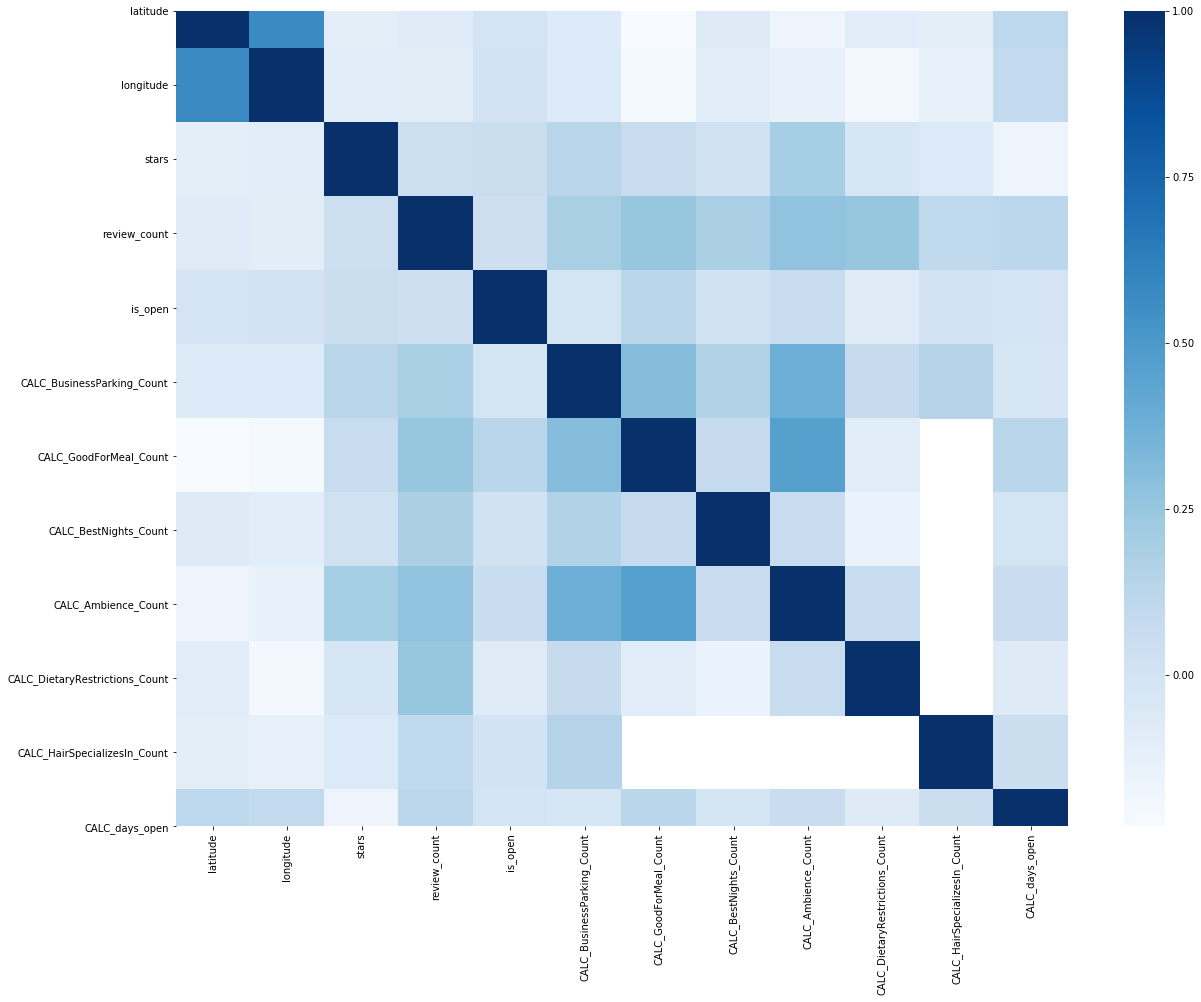

In [14]:
#Visualize correlations between quantitative vars
#variables that are strongly correleated will be removed during the feature selection process.
corr = business_df_flat.corr()
sns.heatmap(corr, cmap="Blues", 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

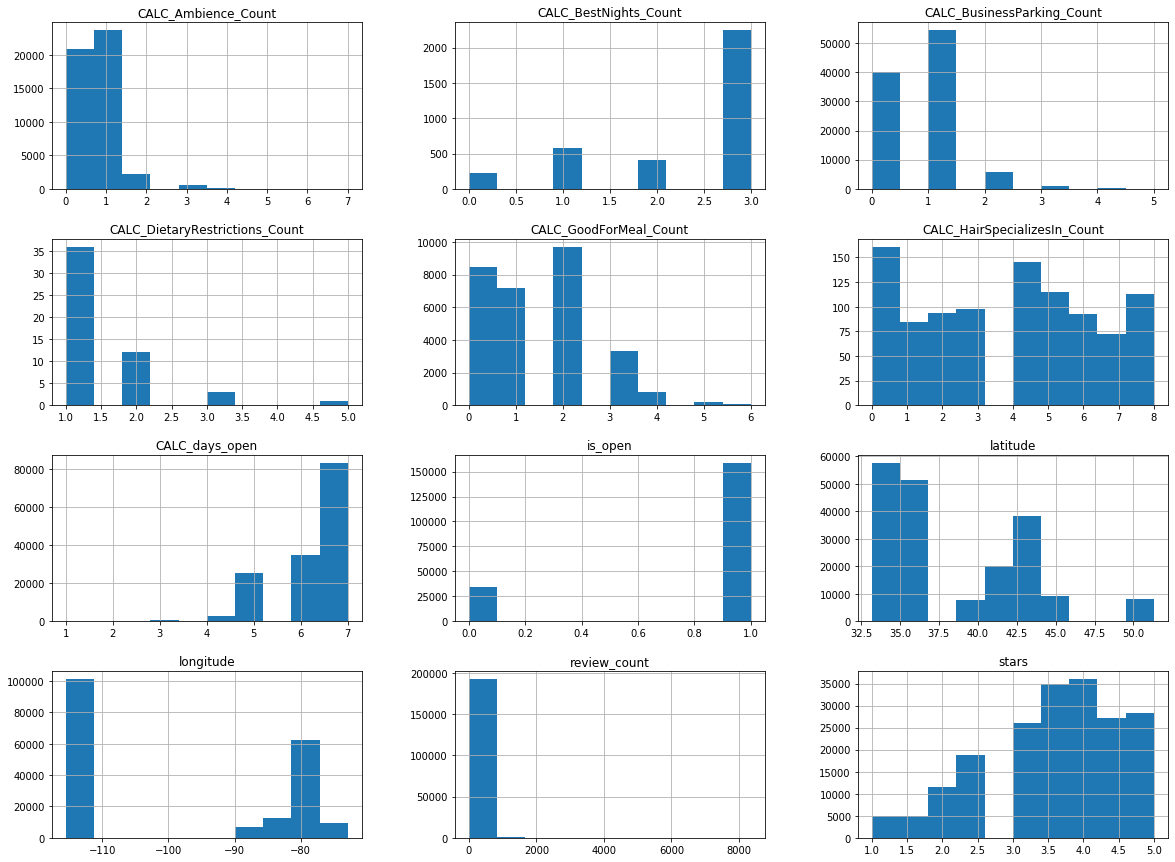

In [15]:
#numeric_fields = business_df_flat.select_dtypes(include=np.number).columns.tolist()
business_df_flat_num = business_df_flat.select_dtypes(include=np.number)
#for field in numeric_fields:
hist = business_df_flat_num.hist()

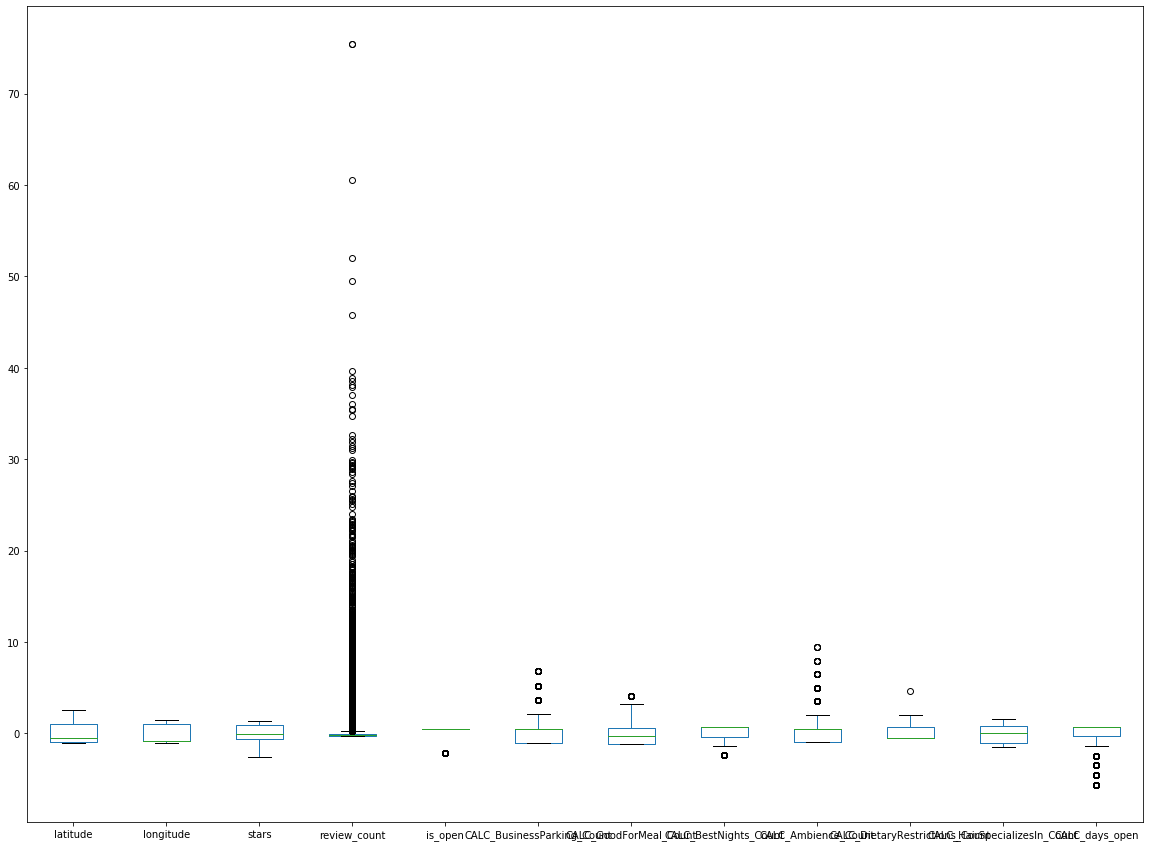

In [16]:
#Scale and center data to compare variance in side-by-side boxplots, and to easily spot outliers.
df_center = (business_df_flat_num - business_df_flat_num.mean())
df_scale = (df_center - df_center.mean())/df_center.std()
df_scale.plot.box()
#At first glance review_count has a lot of outliers, and I will need to remove the extremes to prevent any issues with the model.

In [17]:
#Clean up and save description csv.
#The plots can be obtained via screenshot.

#To make sure field names make it in output csv
row_labels = df_description_nulls.index.values
df_description_nulls.insert (0, "Field", row_labels)
df_to_csv(df_description_nulls, fp + "/business_desc_nulls", ext=".csv", na_rep="")

row_labels = df_description_number.index.values
df_description_number.insert (0, "Param", row_labels)
df_to_csv(df_description_number, fp + "/business_desc_number", ext=".csv", na_rep="")

row_labels = df_description_cat.index.values
df_description_cat.insert (0, "Param", row_labels)
df_to_csv(df_description_cat, fp + "/business_desc_cat", ext=".csv", na_rep="")
business_df = None
business_df_flat = None
business_df_flat_num = None
business_df_flat_cat = None